# Telco Churn EDA

Goals:
- Load data, inspect shape and columns
- Clean `TotalCharges` to numeric, drop `customerID`
- Check churn rate, missingness, and feature types
- Capture notes on categorical levels and leakage risk (expected: none)

In [2]:
import pandas as pd
from pathlib import Path

print("CWD:", Path.cwd())
candidates = [
    Path("data/raw/Telco-Customer-Churn.csv"),
    Path("../data/raw/Telco-Customer-Churn.csv"),
]
raw_path = next((p for p in candidates if p.exists()), None)
if raw_path is None:
    raise FileNotFoundError("Could not find Telco-Customer-Churn.csv; check path and run from project root or adjust candidates")

df = pd.read_csv(raw_path)
df.shape, df.head()

CWD: /Users/tobiomotayo/Developer/ml/churn/notebooks


((7043, 23),
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 3  7795-CFOCW    Male              0      No         No      45           No   
 4  9237-HQITU  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... StreamingTV  \
 0  No phone service             DSL             No  ...          No   
 1                No             DSL            Yes  ...          No   
 2                No             DSL            Yes  ...          No   
 3  No phone service             DSL            Yes  ...          No   
 4                No     Fiber optic             No  ...          No   
 
   StreamingMovies        Contract PaperlessBilling              

In [3]:
# Clean TotalCharges and drop customerID
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"].replace(" ", pd.NA), errors="coerce")
df = df.drop(columns=["customerID"])

target = "Churn"
df[target] = (df[target] == "Yes").astype(int)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,numAdminTickets,numTechTickets,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,0,0,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,0,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,3,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,0,1


In [4]:
# Churn rate and missingness
churn_rate = df[target].mean()
missing = df.isnull().mean().sort_values(ascending=False)
churn_rate, missing.head(10)

(np.float64(0.2653698707936959),
 TotalCharges        0.001562
 gender              0.000000
 SeniorCitizen       0.000000
 numTechTickets      0.000000
 numAdminTickets     0.000000
 MonthlyCharges      0.000000
 PaymentMethod       0.000000
 PaperlessBilling    0.000000
 Contract            0.000000
 StreamingMovies     0.000000
 dtype: float64)

In [5]:
# Save quick summary to reports
from datetime import datetime
reports_dir = Path("reports")
reports_dir.mkdir(exist_ok=True)
summary_path = reports_dir / "eda_summary.md"

lines = [
    f"# EDA Summary ({datetime.now().isoformat(timespec='seconds')})\n",
    f"Churn rate: {churn_rate:.4f}\n",
    "\nTop 10 missingness:\n",
]
for col, frac in missing.head(10).items():
    lines.append(f"- {col}: {frac:.4f}\n")

with open(summary_path, "w") as f:
    f.writelines(lines)

summary_path

PosixPath('reports/eda_summary.md')

In [6]:
# Identify categorical vs numeric features
cat_cols = df.drop(columns=[target]).select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = df.drop(columns=[target]).select_dtypes(exclude=["object", "category"]).columns.tolist()
cat_cols, num_cols

(['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod'],
 ['SeniorCitizen',
  'tenure',
  'MonthlyCharges',
  'TotalCharges',
  'numAdminTickets',
  'numTechTickets'])

/var/folders/w0/hln4ggw93h11bwgkj_jnqry00000gn/T/ipykernel_89261/3212813209.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Churn", "No Churn"], y=[churn_rate, 1 - churn_rate], ax=axes[0], palette=["#d62728", "#2ca02c"])


PosixPath('reports/figures/missingness_top10.png')

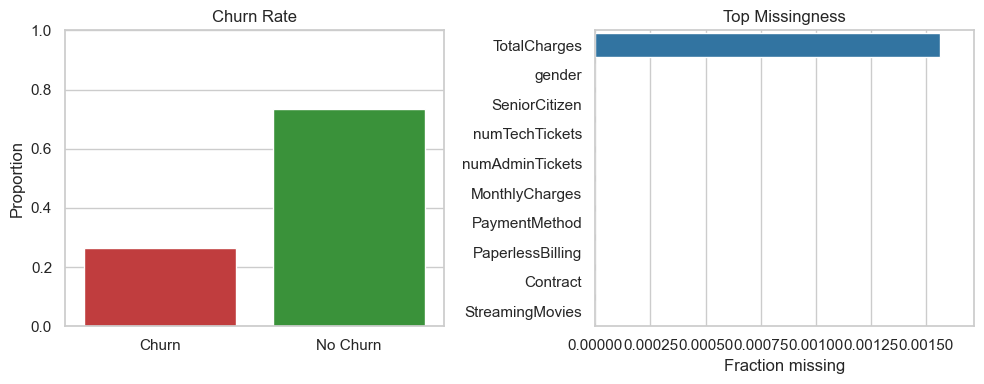

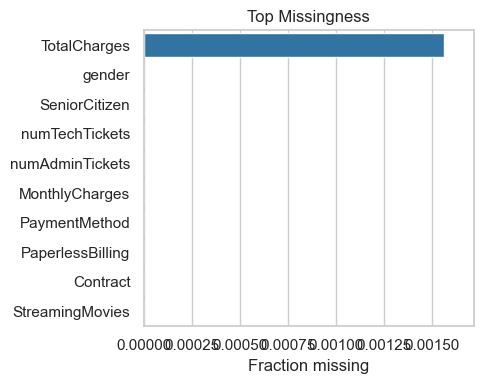

In [7]:
# Quick plots: churn rate and missingness (also save to reports/figures)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Churn rate bar
sns.barplot(x=["Churn", "No Churn"], y=[churn_rate, 1 - churn_rate], ax=axes[0], palette=["#d62728", "#2ca02c"])
axes[0].set_ylim(0, 1)
axes[0].set_ylabel("Proportion")
axes[0].set_title("Churn Rate")

# Missingness bar (top 10)
miss_df = missing.head(10).reset_index()
miss_df.columns = ["column", "missing_frac"]
sns.barplot(y="column", x="missing_frac", data=miss_df, ax=axes[1], color="#1f77b4")
axes[1].set_xlim(0, miss_df["missing_frac"].max() * 1.1 if not miss_df.empty else 1)
axes[1].set_xlabel("Fraction missing")
axes[1].set_ylabel("")
axes[1].set_title("Top Missingness")

plt.tight_layout()

# Save figures
figures_dir = Path("reports/figures")
figures_dir.mkdir(parents=True, exist_ok=True)
churn_plot_path = figures_dir / "churn_rate.png"
missing_plot_path = figures_dir / "missingness_top10.png"
fig.savefig(churn_plot_path)
# Save missingness separately if desired
fig_missing, ax_missing = plt.subplots(figsize=(5, 4))
sns.barplot(y="column", x="missing_frac", data=miss_df, ax=ax_missing, color="#1f77b4")
ax_missing.set_xlim(0, miss_df["missing_frac"].max() * 1.1 if not miss_df.empty else 1)
ax_missing.set_xlabel("Fraction missing")
ax_missing.set_ylabel("")
ax_missing.set_title("Top Missingness")
plt.tight_layout()
fig_missing.savefig(missing_plot_path)
missing_plot_path